# Pixel 2 Pixel Translation Model
Approach that uses Paired Images as dataset.

### Data loading & exploration
We'll first load and explore the images for both photographs and stylized sets.

In [3]:
import glob
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np

In [2]:
# Working with Style A - more realistic style

DATASET_PATH = 'Data/StyleTransfer/monet_style_dataset/monet_style_dataset_A/'

original_filenames = glob.glob(DATASET_PATH + 'original_A/*')
style_filenames    = glob.glob(DATASET_PATH + 'stylized_A/*')

print("No of total images = ", len(original_filenames))

No of total images =  530


In [3]:
def load_images(filepaths, img_size=(512, 512)):
    image_array = []
    for path in filepaths:
        img = load_img(path, target_size=img_size)
        img = img_to_array(img)
        image_array.append(img)
    return np.asarray(image_array).astype('float32')

source_imgs = load_images(original_filenames)
target_imgs = load_images(style_filenames)

np.savez_compressed('monet_A.npz', source_imgs, target_imgs)
print("Saved images as np arrays in monet_A.npz")

Saved images as np arrays in monet_A.npz


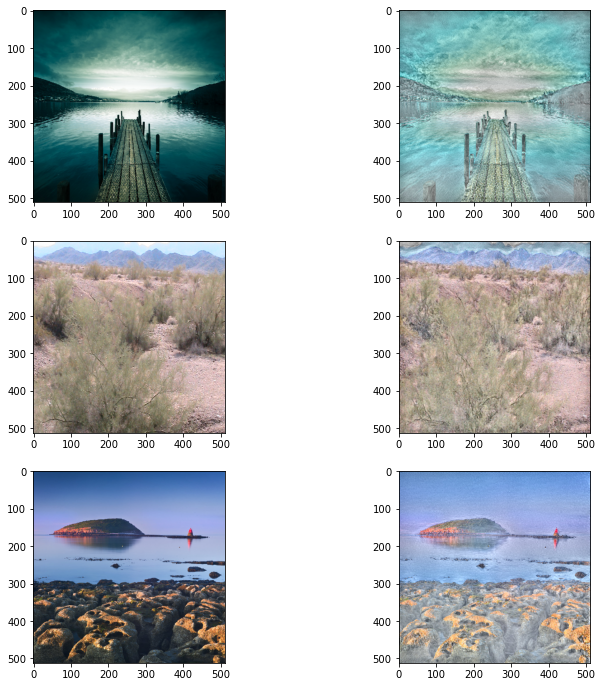

In [4]:
# Loading and exploring the image styles
import matplotlib.pyplot as plt

img_data = np.load('monet_A.npz')
src_imgs, tar_imgs  = img_data['arr_0'], img_data['arr_1']

fig, axes = plt.subplots(3, 2, figsize=(12, 12))
axes[0, 0].imshow(src_imgs[0].astype('uint8'))
axes[0, 1].imshow(tar_imgs[0].astype('uint8'))

axes[1, 0].imshow(src_imgs[1].astype('uint8'))
axes[1, 1].imshow(tar_imgs[1].astype('uint8'))

axes[2, 0].imshow(src_imgs[2].astype('uint8'))
axes[2, 1].imshow(tar_imgs[2].astype('uint8'))

### Defining the GAN models ie the Discriminator and the Generator

#### Discriminator
The discriminator is implemented as a PatchGAN. A PatchGAN is a method where instead of classifying the entire image as real or fake, the model samples and classifies `w x w` sized patches of the image and the overall decision of fake or real is made by averaging the results from the patches

In [10]:
from keras.initializers import RandomNormal
from keras.optimizers import Adam
from keras.layers import Conv2D, Conv2DTranspose, LeakyReLU, Activation, BatchNormalization, Dropout, Concatenate, Input
from keras.models import Model

In [11]:
def create_discriminator(shape):
    # The inital weights are chosen using a Randomized Normal distribution
    weight_seed = RandomNormal(stddev=0.03)
    # defining the input layers for the original and stylized images
    src_inp  = Input(shape=shape)
    tar_inp  = Input(shape=shape)
    net_inp = Concatenate()([src_inp, tar_inp])
    # Convolution blocks that extract features from the input layers
    # using Leaky ReLU as activation function
    conv_1 = Conv2D(64, kernel_size=(4, 4),
                  strides=(2,2), padding='same',
                  kernel_initializer=weight_seed)(net_inp)
    conv_1 = LeakyReLU(alpha=0.25)(conv_1)

    conv_2 = Conv2D(128, kernel_size=(4,4),
                  strides=(2,2), padding='same',
                  kernel_initializer=weight_seed)(conv_1)
    conv_2 = LeakyReLU(alpha=0.25)(conv_2)

    conv_3 = Conv2D(256, kernel_size=(4,4),
                  strides=(2,2), padding='same',
                  kernel_initializer=weight_seed)(conv_2)
    conv_3 = LeakyReLU(alpha=0.25)(conv_3)

    conv_4 = Conv2D(512, kernel_size=(4,4),
                  strides=(2,2), padding='same',
                  kernel_initializer=weight_seed)(conv_3)
    conv_4 = LeakyReLU(alpha=0.25)(conv_4)

    conv_5 = Conv2D(512, kernel_size=(4,4),
                  padding='same',
                  kernel_initializer=weight_seed)(conv_4)
    conv_5 = LeakyReLU(alpha=0.25)(conv_5)

    patch_output = Conv2D(1, (4,4),
                          padding='same',
                          kernel_initializer=weight_seed)(conv_5)
    patch_output = Activation('sigmoid')(patch_output)

    model = Model([src_inp, tar_inp], patch_output)
    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(lr=0.0005),
                  loss_weights=[0.5])
    return model

#### Generator

As the generator must produce an entire image array from the inputs its model is much more complex than the discriminator. Generator is an autoencoder which uses a U-net architecture. It dowsamples the input image to a bottleneck feature layer from which it is upsampled back to the input image size. Skip connections are made all across the U-net architecture to conserve and save the gradient from vanishing.

In [7]:
# Since the generator is a sequence of standardized encoders and decoders applied in sequence we first define a enocder and decoder layer

def encoder_block(layer_prev, num_filers, is_batchnorm=True):
    block = Conv2D(num_filers, kernel_size=(4,4),
                   strides=(2,2), padding='same',
                   kernel_initializer=RandomNormal(0.03)) (layer_prev)
    if is_batchnorm:
        block = BatchNormalization()(block, training=True)
    block = LeakyReLU(0.25)(block)
    return block

def decoder_block(layer_prev, skip_layer, num_filters, is_dropout=True):
    block = Conv2DTranspose(num_filters, kernel_size=(4,4),
                   strides=(2,2), padding='same',
                   kernel_initializer=RandomNormal(0.03)) (layer_prev)
    block = BatchNormalization()(block, training=True)
    # A high dropout range of 50%
    if is_dropout:
        block = Dropout(0.5)(block)
    
    block = Concatenate()([block, skip_layer])
    block = Activation('relu')(block)
    return block

def create_generator(shape=(256, 256, 3)):
    weight_seed = RandomNormal(0.03)
    img_inp = Input(shape=shape)
    # sequence of encoders and decoders, we use 7 layers on each side of the U-net
    enc1 = encoder_block(img_inp, 64, is_batchnorm=False)
    enc2 = encoder_block(enc1, 128)
    enc3 = encoder_block(enc2, 256)
    enc4 = encoder_block(enc3, 512)
    enc5 = encoder_block(enc4, 512)
    enc6 = encoder_block(enc5, 512)
    enc7 = encoder_block(enc6, 512)
    # bottleneck layer
    bottleneck = Conv2D(512, (4,4),
                        strides=(2,2),
                        padding='same',
                        kernel_initializer=weight_seed)(enc7)
    bottleneck = Activation('relu')(bottleneck)
    
    dec1 = decoder_block(bottleneck, enc7, 512)
    dec2 = decoder_block(dec1, enc6, 512)
    dec3 = decoder_block(dec2, enc5, 512)
    dec4 = decoder_block(dec3, enc4, 512, is_dropout=False)
    dec5 = decoder_block(dec4, enc3, 256, is_dropout=False)
    dec6 = decoder_block(dec5, enc2, 128, is_dropout=False)
    dec7 = decoder_block(dec6, enc1, 64 , is_dropout=False)

    generated = Conv2DTranspose(3, (4,4),
                                strides=(2,2),
                                padding='same',
                                kernel_initializer=weight_seed)(dec7)
    generated = Activation('tanh')(generated)
    
    model = Model(img_inp, generated)
    return model

### Model
We define the GAN model which is a stacking of the generator on top of the discriminator. This composite model is used to train and update the generator hence the discriminator weights are freezed and the discriminator directly works on the generator output. The generator is updated to minimize the loss predicted by the discriminator for generated images marked as *real*.

An input of a src image is feeded to generator and to the discriminator, while the output of the generator is connected to the discriminator as the corresponding *target* image. The discriminator then predicts the likelihood that the generator was a real translation of the source image.

Therefore the generator works to minimize a weighted sum of both the adversarial loss and loss b/w generated and real images.


In [8]:
def GAN_model(generator, discriminator, shape):
    # Making the discriminator weights untrainable
    for layer in discriminator.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False 
    inp = Input(shape=shape)
    generated_img = generator(inp)
    discriminator_pred = discriminator([inp, generated_img])

    Gan = Model(inp, [discriminator_pred, generated_img])
    Gan.compile(loss=['binary_crossentropy', 'mae'],
                optimizer=Adam(lr=0.0005, beta_1=0.5),
                loss_weights=[1, 100])
    return Gan

#### Image batches generation
We define functions that'll fetch real samples (from dataset) and fake samples (generator output) when we need them.

In [15]:
def gen_fake_instances(generator, true_imgs, patch_shape):
    features = generator.predict(true_imgs)
    # labels of 0 indicating 'fake'
    labels  = np.zeros((len(features), patch_shape, patch_shape, 1))
    return features, labels

def gen_real_instances(dataset, num_samples, patch_shape):
    source, target = dataset
    indices = np.random.randint(0, source.shape[0], num_samples)
    selected_src, selected_tar = source[indices], target[indices]
    # labels of 1 indicating real
    labels = np.ones((num_samples, patch_shape, patch_shape, 1))
    return [selected_src, selected_tar], labels

#### Training the model and the main code

It is important to note here that we will be training out model in a stochastic manner with a batch size of 1. This is considering that GAN models usually do not converge and we need to extract the best minima possible.

In [16]:
from matplotlib import pyplot

def eval_performance(step, g_model, dataset, n_samples=3):
	# select a sample of input images
	[X_realA, X_realB], _ = gen_real_instances(dataset, n_samples, 1)
	# generate a batch of fake samples
	X_fakeB, _ = gen_fake_instances(g_model, X_realA, 1)
	# Normalization of [-1,1] to [0,1]
	X_realA = (X_realA + 1) / 2.0
	X_realB = (X_realB + 1) / 2.0
	X_fakeB = (X_fakeB + 1) / 2.0
	
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X_realA[i])
	
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		pyplot.imshow(X_fakeB[i])
	
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + n_samples*2 + i)
		pyplot.axis('off')
		pyplot.imshow(X_realB[i])
	
	# save generator model and plots of the sampled style transfer
	filename1 = 'plot_%06d.png' % (step+1)
	pyplot.savefig(filename1)
	pyplot.close()
	
	filename2 = 'model_rev_%06d.h5' % (step+1)
	g_model.save(filename2)
	print('Saved model as %s' % filename2)

def Train(discriminator, generator, GAN, dataset):
    n_patch = discriminator.output_shape[1]
    train_src, train_tar = dataset
    epochs = 50
    batches_per_epoch = len(train_src)
    num_steps = epochs * batches_per_epoch
    for i in range(num_steps):
        [X_real_src, X_real_tar], y_real = gen_real_instances(dataset, 1, n_patch)
        X_fake_tar, y_fake = gen_fake_instances(generator, X_real_src, n_patch)

        # Independant training of the discrminator to correlate Real Photographs with respective paintings
        disc_loss_indie = discriminator.train_on_batch([X_real_src, X_real_tar], y_real)
        # Training the discriminator on identifying fake from false of generator output
        disc_loss_adv   = discriminator.train_on_batch([X_real_src, X_fake_tar], y_fake)

        gen_loss, _, _ = GAN.train_on_batch(X_real_src, [y_real, X_real_tar])

        print('>%d, Independant Discriminator loss[%.3f] Adversarial Discrimator loss[%.3f] Generator loss[%.3f]' % (i+1, disc_loss_indie, disc_loss_adv, gen_loss))
        # We shall save the model and display the performance after each 10 epochs
        if (i+1) % (batches_per_epoch * 10) == 0:
            eval_performance(i, generator, dataset)

In [5]:
Data_arrays = np.load('monet_A.npz')
X_src, X_tar = Data_arrays['arr_0'], Data_arrays['arr_1']
X_src = (X_src - 127.5) / 127.5
X_tar = (X_tar - 127.5) / 127.5
Dataset = [X_src, X_tar]

In [10]:
img_shape = Dataset[0].shape[1:]

discriminator = create_discriminator(img_shape)
generator     = create_generator(img_shape)

GAN = GAN_model(generator, discriminator, img_shape)

# We run the training for the GAN model which updates the disriminator and the generator models in an adversarial manner.
# The training progresses until we get a model that gives us a sufficiently good enough styled image, with a max cap of 50 epochs this model is trained
Train(discriminator, generator, GAN, Dataset)

1/1 [==============================] - 0s 461ms/step
>1, Independant Discriminator loss[0.251] Adversarial Discrimator loss[18.922] Generator loss[67.843]
1/1 [==============================] - 0s 24ms/step
>2, Independant Discriminator loss[0.146] Adversarial Discrimator loss[0.312] Generator loss[48.114]
1/1 [==============================] - 0s 22ms/step
>3, Independant Discriminator loss[0.901] Adversarial Discrimator loss[0.853] Generator loss[43.763]
1/1 [==============================] - 0s 24ms/step
>4, Independant Discriminator loss[0.419] Adversarial Discrimator loss[0.380] Generator loss[35.548]
1/1 [==============================] - 0s 24ms/step
>5, Independant Discriminator loss[0.379] Adversarial Discrimator loss[0.219] Generator loss[43.647]
1/1 [==============================] - 0s 27ms/step
>6, Independant Discriminator loss[0.319] Adversarial Discrimator loss[0.264] Generator loss[38.305]
1/1 [==============================] - 0s 24ms/step
>7, Independant Discriminato

KeyboardInterrupt: 

## Actual Image translation with the trained model

In [32]:
from keras.models import load_model

# After training for more than 20 epochs we end up with 2 models out of which the second model seems to have better image translation quality and hence we will use the second model for style transfer
style_model = load_model('model_010600.h5')

In [25]:
from matplotlib import pyplot

def plot_images(original, styled, expected, rev=False):
    imgs = np.vstack((original, styled, expected))
    imgs = (imgs + 1) / 2.0
    if rev == False:
        titles = ['Original', 'Styled', 'Expected']
    else:
        titles = ['Painting styled', 'Photograph', 'Expected']
    fig, ax = pyplot.subplots(1, 3, figsize=(12,12))
    ax[0].imshow(imgs[0])
    ax[0].set_title(titles[0])
    ax[1].imshow(imgs[1])
    ax[1].set_title(titles[1])
    ax[2].imshow(imgs[2])
    ax[2].set_title(titles[2])
    pyplot.show()

1/1 [==============================] - 0s 32ms/step


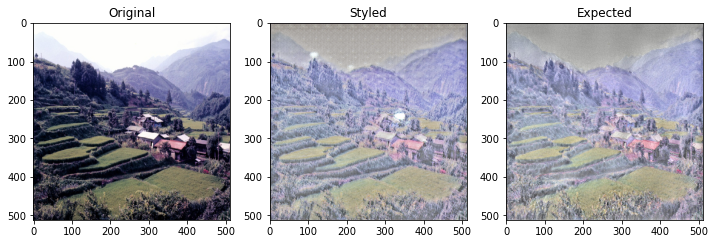

In [9]:
# select a random image and style it and check with the expected style
idx = np.random.randint(0, len(Dataset[0]), 1)
original, expected = Dataset[0][idx], Dataset[1][idx]

styled = style_model.predict(original)
plot_images(original, styled, expected)

1/1 [==============================] - 22s 22s/step


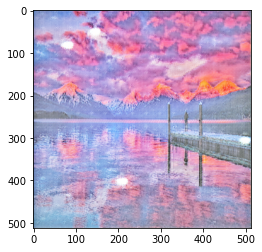

In [6]:
# Now since our model is trained and can style individual images, we test it with a scenery image that is NOT present in the dataset

scenery = load_img("External_captures/lake.jpg", target_size=(512,512))
pixels = img_to_array(scenery)
pixels = (pixels - 127.5) / 127.5
pixels = np.expand_dims(pixels, 0)

construction = style_model.predict(pixels)
output = (construction + 1) / 2.0
pyplot.imshow(output[0])
pyplot.show()

## Reverse Translation of Painting styled images to photgraphs

To perform the reverse translation with GAN, its as simple as exchanging the order in which the Arrays are loaded from the .npz file and just return the reversed arrays for training.

In [4]:
Data_arrays_rev = np.load('monet_A.npz')
X_src, X_tar = Data_arrays_rev['arr_0'], Data_arrays_rev['arr_1']
X_src = (X_src - 127.5) / 127.5
X_tar = (X_tar - 127.5) / 127.5
Dataset_rev = [X_tar, X_src]

In [17]:
img_shape = Dataset_rev[0].shape[1:]

discriminator_2 = create_discriminator(img_shape)
generator_2     = create_generator(img_shape)

GAN_2 = GAN_model(generator_2, discriminator_2, img_shape)

Train(discriminator_2, generator_2, GAN_2, Dataset_rev)

1/1 [==============================] - 20s 20s/step
>1, Independant Discriminator loss[0.402] Adversarial Discrimator loss[8.477] Generator loss[99.654]
1/1 [==============================] - 0s 26ms/step
>2, Independant Discriminator loss[0.046] Adversarial Discrimator loss[0.066] Generator loss[104.542]
1/1 [==============================] - 0s 34ms/step
>3, Independant Discriminator loss[0.337] Adversarial Discrimator loss[0.348] Generator loss[94.843]
1/1 [==============================] - 0s 25ms/step
>4, Independant Discriminator loss[0.966] Adversarial Discrimator loss[0.013] Generator loss[44.935]
1/1 [==============================] - 0s 29ms/step
>5, Independant Discriminator loss[0.291] Adversarial Discrimator loss[0.197] Generator loss[37.717]
1/1 [==============================] - 0s 30ms/step
>6, Independant Discriminator loss[0.134] Adversarial Discrimator loss[0.244] Generator loss[90.688]
1/1 [==============================] - 0s 42ms/step
>7, Independant Discriminator

KeyboardInterrupt: 

### Generation of Photographs from paintings

In [20]:
from keras.models import load_model

destyle_model = load_model("model_rev_005300.h5")

1/1 [==============================] - 0s 434ms/step


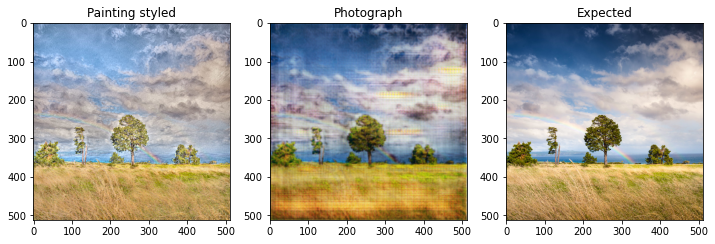

In [26]:
indices = np.random.randint(0, len(Dataset_rev[0]), 1)
original, expected = Dataset_rev[0][indices], Dataset_rev[1][indices]

styled = destyle_model.predict(original)
plot_images(original, styled, expected, rev=True)

### Styling of Photos taken from drone views

In [34]:
from matplotlib import pyplot as plt

def style_external_image(external):
  pixels = img_to_array(external)
  pixels = (pixels - 127.5) / 127.5
  pixels = np.expand_dims(pixels, 0)
  
  construction = style_model.predict(pixels)
  output = (construction + 1) / 2.0
  return output[0]

1/1 [==============================] - 0s 32ms/step


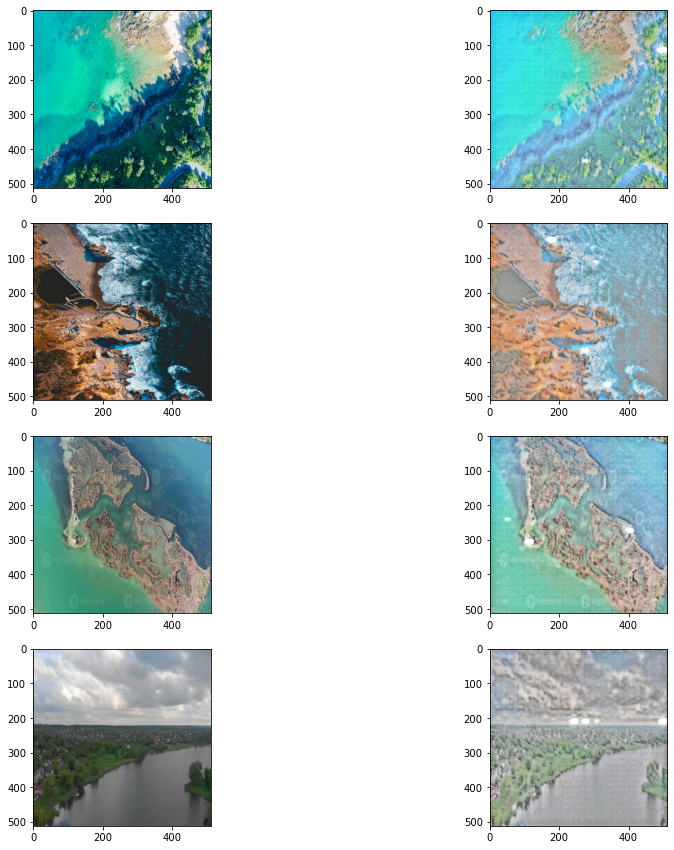

In [38]:
drone1 = load_img("External_captures/drone1.jpg", target_size=(512,512))
drone2 = load_img("External_captures/drone2.jpg", target_size=(512,512))
drone3 = load_img("External_captures/drone3.jpg", target_size=(512,512))
drone4 = load_img("External_captures/drone4.jpg", target_size=(512,512))

fig, ax = plt.subplots(4, 2, figsize=(15, 15))

ax[0,0].imshow(drone1)
ax[0,1].imshow(style_external_image(drone1))
ax[1,0].imshow(drone2)
ax[1,1].imshow(style_external_image(drone2))
ax[2,0].imshow(drone3)
ax[2,1].imshow(style_external_image(drone3))
ax[3,0].imshow(drone4)
ax[3,1].imshow(style_external_image(drone4))